In [37]:
import numpy as np
from casadi import *

### Build dynamical system

In [38]:
# basic states
nx = 6
nu = 1
x = SX.sym('x', nx) #[pos, ang1, ang2, pos_dot, ang1_dot, ang2_dot]
u = SX.sym('u', nu)
# settings
dt = 0.2
L1 = 0.5
L2 = 0.5
cart_mass = 0.6
rod1_mass = 0.2
rod2_mass = 0.2
# control variable limit
force_list = [-4,4] 
# inertia
Jrod_1 = rod1_mass * L1 ** 2 / 3
Jrod_2 = rod2_mass * L2 ** 2 / 3
g = 9.8 # gravity

In [39]:
h1 = cart_mass + rod1_mass + rod2_mass
h2 = rod1_mass * L1/2 + rod2_mass * L1
h3 = rod2_mass * L2/2
h4 = rod1_mass * (L1/2) ** 2 + rod2_mass * L1 ** 2 + Jrod_1
h5 = rod2_mass * L2/2 * L1
h6 = rod2_mass * (L2/2) ** 2 + Jrod_2
h7 = rod1_mass * L1/2 * g + rod2_mass * L1 * g
h8 = rod2_mass * L2/2 * g

In [40]:
M = SX.zeros(3,3)
M[0,0] = h1
M[0,1] = h2 * cos(x[1])
M[0,2] = h3 * cos(x[2])
M[1,0] = h2 * cos(x[1])
M[1,1] = h4
M[1,2] = h5 * cos(x[1] - x[2])
M[2,0] = h3 * cos(x[2])
M[2,1] = h5 * cos(x[1] - x[2])
M[2,2] = h6

In [41]:
C = SX.zeros(3,3)
C[0,0] = 0
C[0,1] = -h2 * x[4] * sin(x[1])
C[0,2] = -h3 * x[5] * sin(x[2])
C[1,0] = 0
C[1,1] = 0
C[1,2] = h5 * x[5] * sin(x[1] - x[2])
C[2,0] = 0
C[2,1] = -h5 * x[4] * sin(x[1] - x[2])
C[2,2] = 0

In [42]:
g = SX.zeros(3,1)
g[0,0] = 0
g[1,0] = -h7 * sin(x[1])
g[2,0] = -h8 * sin(x[2])

Qq = SX.zeros(3,1)
Qq[0,0] = u

In [43]:
x1_d = x[3:]
x2_d = inv(M)@(Qq-g-C@x[3:])
xdot = vertcat(x1_d, x2_d)
system = Function("sys", [x,u], [xdot])

### stimulate the system, integrator can't be set up, because this system is underactuated

In [44]:
ode = {'x': x, 'ode': xdot, 'p': u}
opts = {'tf': dt}
ode_solver = integrator('F', 'idas', ode, opts)

Text(0.5, 0, 'time')

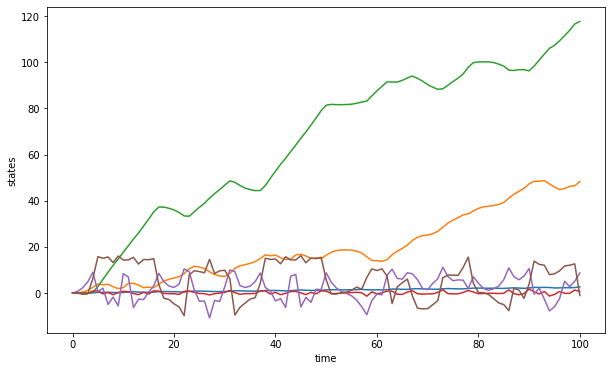

In [45]:
import matplotlib.pyplot as plt
# Define the total steps to simulate
N_sim = 100
# Define the initial condition
x_0 = np.array([0.1,0.1,0.1,0.1,0.1,0.1]).reshape(nx,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

res_x_sundials = [x_0]

for i in range(N_sim):
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    res_x_sundials.append(x_next)
    x_0 = x_next
res_x_sundials = np.concatenate(res_x_sundials,axis=1)

fig, ax = plt.subplots(figsize=(10,6))

# plot the states
lines = ax.plot(res_x_sundials.T)


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

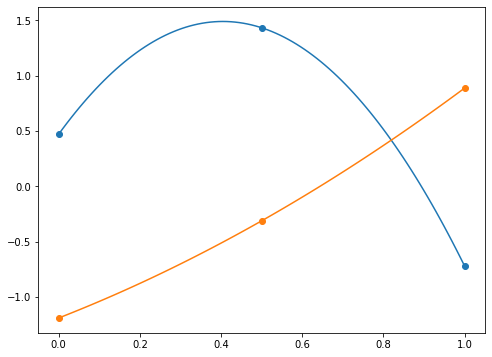

In [46]:
def L(tau_col, tau, j):
    l = 1
    for k in range(len(tau_col)):
        if k!=j:
            l *= (tau-tau_col[k])/(tau_col[j]-tau_col[k]) 
    return l

def LgrInter(tau_col, tau, xk):
    z = 0
    for j in range(K):
        z += L(tau_col, tau, j)*xk[j,:]
        
    return z

# collocation degree.
K = 3

# Fix the random seed (results are always the same)
np.random.seed(1234)

# Get some linearly spaced collocation points between 0 and 1.
tau_col = np.linspace(0,1, num=K)
# Get some xk values for the collocation points.
xk = np.random.randn(K,2)

# Get the evaluated interpolation polynomial.
tau = np.linspace(0,1,100).reshape(-1,1)
x_interpolation = LgrInter(tau_col, tau, xk)

fig, ax= plt.subplots(figsize=(8,6))

ax.plot(tau, x_interpolation)
ax.set_prop_cycle(None)
ax.plot(tau_col, xk,'o')

In [47]:
# collocation degree
K = 9

# collocation points (excluding 0)
tau_col = collocation_points(K,'radau')

# collocation points (including 0)
tau_col = [0]+tau_col

print(tau_col)

[0, 0.017779915147363934, 0.09132360789979432, 0.21430847939563036, 0.3719321645832724, 0.5451866848034266, 0.7131752428555695, 0.8556337429578544, 0.9553660447100301, 1.0]


In [48]:
# Your code here!
tau = SX.sym('tau')

A = np.zeros((K+1,K+1))

for j in range(K+1):
    dLj = gradient(L(tau_col, tau, j), tau)
    dLj_fcn = Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j,k] = dLj_fcn(tau_col[k])

D = np.zeros((K+1,1))

for j in range(K+1):
    Lj = L(tau_col, tau, j)
    Lj_fcn = Function('Lj', [tau], [Lj])
    D[j] = Lj_fcn(1)

In [49]:
# Initialize empty list of constraints
g = []

# 01 - Your code here!
# States at all collocation points
X = SX.sym('X', nx, K+1)
# Initial state
x_init = SX.sym('x0', nx)
# control input
u = SX.sym('u', nu)
# 01


# 02 - Your code here!
# Append constraint to enforce initial state
g0 = X[:,0]-x_init
g.append(g0)
# 02


# 03 - Your code here!
for k in range(1,K+1):
    gk = -dt*system(X[:,k], u)
    for j in range(K+1):
        gk += A[j,k]*X[:,j]
        
    g.append(gk)
# 03


# 04 - Your code here!    
g = vertcat(*g)  
# 04


# 05 - Your code here!
# dictionary for nlpsol object (no objective function required)
nlp = {'x':X.reshape((-1,1)), 'g':g, 'p':vertcat(x_init, u)}

# create nlpsol object (with ipopt)
S = nlpsol('S', 'ipopt', nlp)

# 05

In [50]:
# Define the initial condition
x_0 = np.array([0.1,0.1,0.1,0.1,0.1,0.1]).reshape(6,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

# Initialize result list
res_x_oc = [x_0]

In [51]:
# Your code here!
for i in range(N_sim):
    res_oc = S(lbg=0, ubg=0, p=vertcat(x_0, u_k))
    X_k = res_oc['x'].full().reshape(K+1,nx)
    x_next = X_k.T@D
    res_x_oc.append(x_next)
    x_0 = x_next

# Make an array from the list of arrays:
res_x_oc = np.concatenate(res_x_oc,axis=1)

0 6.49e+01 0.00e+00  -1.0 2.87e+02    -  1.00e+00 4.88e-04h 12
   4  0.0000000e+00 6.49e+01 0.00e+00  -1.0 2.80e+02    -  1.00e+00 4.88e-04h 12
   5  0.0000000e+00 6.49e+01 0.00e+00  -1.0 2.72e+02    -  1.00e+00 4.88e-04h 12
   6  0.0000000e+00 6.48e+01 0.00e+00  -1.0 2.63e+02    -  1.00e+00 4.88e-04h 12
   7  0.0000000e+00 6.48e+01 0.00e+00  -1.0 2.53e+02    -  1.00e+00 4.88e-04h 12
   8  0.0000000e+00 6.48e+01 0.00e+00  -1.0 2.44e+02    -  1.00e+00 4.88e-04h 12
   9  0.0000000e+00 6.47e+01 0.00e+00  -1.0 2.34e+02    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  0.0000000e+00 6.47e+01 0.00e+00  -1.0 2.23e+02    -  1.00e+00 4.88e-04h 12
  11  0.0000000e+00 2.80e+03 0.00e+00  -1.0 2.13e+02    -  1.00e+00 1.00e+00w  1
  12  0.0000000e+00 1.75e+07 0.00e+00  -1.0 1.27e+04    -  1.00e+00 1.00e+00w  1
  13  0.0000000e+00 6.57e+06 0.00e+00  -1.0 2.80e+05    -  1.00e+00 1.00e+00w  1
  14  0.0000000e+00 6.47e+01 0.00e+00  -1.0 6.

Text(0.5, 1.0, 'Orthogonal collocation vs. Sundials')

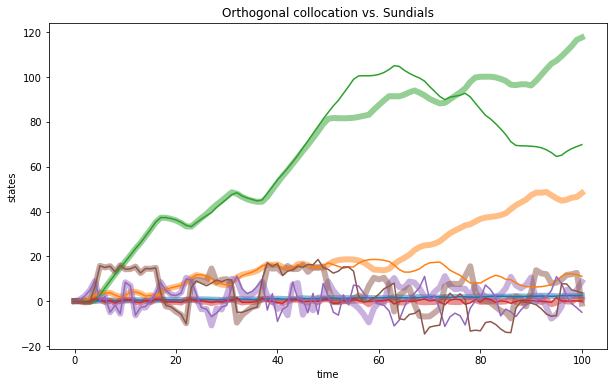

In [52]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
ax.plot(res_x_sundials.T, alpha=0.5, linewidth=6)
ax.set_prop_cycle(None)
ax.plot(res_x_oc.T)


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')
ax.set_title('Orthogonal collocation vs. Sundials')

In [53]:
Q = 20
Q = Q*np.diag(np.ones(nx))
print(Q)

[[20.  0.  0.  0.  0.  0.]
 [ 0. 20.  0.  0.  0.  0.]
 [ 0.  0. 20.  0.  0.  0.]
 [ 0.  0.  0. 20.  0.  0.]
 [ 0.  0.  0.  0. 20.  0.]
 [ 0.  0.  0.  0.  0. 20.]]


In [54]:
R = 10
R = np.diag(R*np.ones(nu))
print(R)

[[10.]]


In [55]:
# stage cost
stage_cost = x.T@Q@x+ u.T@R@u
stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

# terminal cost
terminal_cost = x.T@Q@x
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

In [56]:
N = 20

In [57]:
# state constraints
lb_x = -10*np.ones((nx,1))
ub_x = 10*np.ones((nx,1))
# input constraints, at least around 12
lb_u = -20*np.ones((nu,1))
ub_u = 20*np.ones((nu,1))

In [58]:
from casadi.tools import *

In [59]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1, K+1]),
    entry('u', shape=nu, repeat=[N])
])

In [60]:
print(opt_x)

symbolic SX with following structure:
Structure with total size 1280.
Structure holding 2 entries.
  Order: ['x', 'u']
  x = repeated([21, 10]): 6x1
  u = repeated([20]): 1x1



In [61]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [62]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [63]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [64]:
# 01 - Your code here!
x_init = SX.sym('x_init', nx)

x0 = opt_x['x', 0, 0]

g.append(x0-x_init)
lb_g.append(np.zeros((nx,1)))
ub_g.append(np.zeros((nx,1)))
# 01

for i in range(N):
    # 02 - Your code here!
    # objective
    J += stage_cost_fcn(opt_x['x',i,0], opt_x['u',i])
    # 02
    
    # 03 - Your code here!
    # equality constraints (system equation)
    for k in range(1,K+1):
        gk = -dt*system(opt_x['x',i,k], opt_x['u',i])
        for j in range(K+1):
            gk += A[j,k]*opt_x['x',i,j]
            
        
        g.append(gk)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))   
    # 03

    
    # 04 - Your code here!
    x_next = horzcat(*opt_x['x',i])@D
    g.append(x_next - opt_x['x', i+1, 0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    # 04
    

# 05 - Your code here!
J += terminal_cost_fcn(opt_x['x', N, 0])
# 05

# 06 - Your code here!
g = vertcat(*g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':x_init}
mpc_solver = nlpsol('solver','ipopt',prob)
# 06

In [65]:
# Define the initial condition
x_0 = np.array([0.5,0.5,0.5,0.5,0.5,0.5]).reshape(6,1)
mpc_res = mpc_solver(p=x_0, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    13926
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2126

Total number of variables............................:     1280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1280
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1206
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [66]:
 opt_x_k = opt_x(mpc_res['x'])

In [67]:
X_k = horzcat(*opt_x_k['x',:,0,:])
U_k = horzcat(*opt_x_k['u',:])

Text(0.5, 0, 'time')

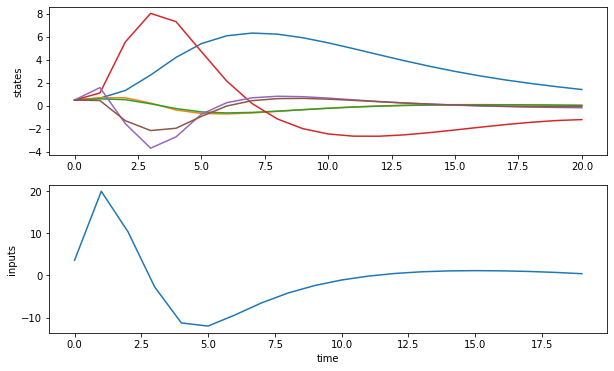

In [68]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(X_k.T)
ax[1].plot(U_k.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time')

In [69]:
# Define the initial state
x_0 = np.array([0.5,0.5,0.5,0.5,0.5,0.5]).reshape(6,1)
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

In [70]:
for i in range(N_sim):
    # 01 - Your code here!
    # solve optimization problem
    mpc_res = mpc_solver(p=x_0, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)
    
    # optionally: Warmstart the optimizer by passing the previous solution as an initial guess!
    if i>0:
        mpc_res = mpc_solver(p=x_0, x0=opt_x_k, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)
        
    # 01
        
        
    # 02 - Your code here!
    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]
    # 02

    # 03 - Your code here!
    # simulate the system
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    # 03
    
    # 04 - Your code here!
    # Update the initial state
    x_0 = x_next
    # 04
    
    # 05 - Your code here!    
    # Store the results
    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)
    # 05
    
# Make an array from the list of arrays:
res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)

.1983822e-03 2.78e-17 1.42e-16  -8.6 9.25e-13    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.1983821609978451e-03    1.1983821609978451e-03
Dual infeasibility......:   1.4217268025162140e-16    1.4217268025162140e-16
Constraint violation....:   2.7755575615628914e-17    2.7755575615628914e-17
Complementarity.........:   2.5059035598505243e-09    2.5059035598505243e-09
Overall NLP error.......:   2.5059035598505243e-09    2.5059035598505243e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function e

Text(0.5, 0, 'time')

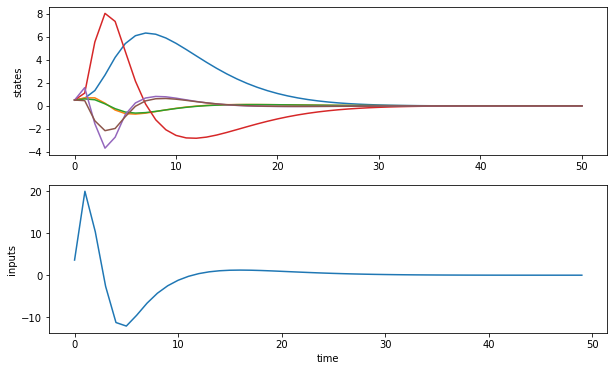

In [71]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(res_x_mpc.T)
ax[1].plot(res_u_mpc.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time') # 20 time step means 4 seconds